In [36]:
%matplotlib inline
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Activation, Masking, BatchNormalization
from tensorflow.keras import backend as k
from sklearn.preprocessing import normalize
import pandas as pd
from six.moves import xrange
import matplotlib.pyplot as plt
from tensorflow.keras.layers import GRU, Lambda, TimeDistributed
from tensorflow.keras.optimizers.legacy import RMSprop, Adam
from tensorflow.keras.callbacks import History, TerminateOnNaN

np.random.seed(2)
pd.set_option("display.max_rows",1000)

In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from wtte import weibull as weibull
from wtte import wtte as wtte
from wtte.wtte import WeightWatcher

In [3]:
"""
    Discrete log-likelihood for Weibull hazard function on censored survival data
    y_true is a (samples, 2) tensor containing time-to-event (y), and an event indicator (u)
    ab_pred is a (samples, 2) tensor containing predicted Weibull alpha (a) and beta (b) parameters
    For math, see https://ragulpr.github.io/assets/draft_master_thesis_martinsson_egil_wtte_rnn_2016.pdf (Page 35)
"""
def weibull_loglik_discrete(y_true, ab_pred, name=None):
    y_ = y_true[:, 0]
    u_ = y_true[:, 1]
    a_ = ab_pred[:, 0]
    b_ = ab_pred[:, 1]
    hazard0 = k.pow((y_ + 1e-35) / a_, b_)
    hazard1 = k.pow((y_ + 1) / a_, b_)
    return -1 * k.mean(u_ * k.log(k.exp(hazard1 - hazard0) - 1.0) - hazard1)
"""
    Not used for this model, but included in case somebody needs it
    For math, see https://ragulpr.github.io/assets/draft_master_thesis_martinsson_egil_wtte_rnn_2016.pdf (Page 35)
"""
def weibull_loglik_continuous(y_true, ab_pred, name=None):
    y_ = y_true[:, 0]
    u_ = y_true[:, 1]
    a_ = ab_pred[:, 0]
    b_ = ab_pred[:, 1]
    ya = (y_ + 1e-35) / a_
    return -1 * k.mean(u_ * (k.log(b_) + b_ * k.log(ya)) - k.pow(ya, b_))
"""
    Custom Keras activation function, outputs alpha neuron using exponentiation and beta using softplus
"""
def activate(ab):
    a = k.exp(ab[:, 0])
    b = k.softplus(ab[:, 1])
    a = k.reshape(a, (k.shape(a)[0], 1))
    b = k.reshape(b, (k.shape(b)[0], 1))
    return k.concatenate((a, b), axis=1)

In [4]:
"""
    Load and parse engine data files into:
       - an (engine/day, observed history, sensor readings) x tensor, where observed history is 100 days, zero-padded
         for days that don't have a full 100 days of observed history (e.g., first observed day for an engine)
       - an (engine/day, 2) tensor containing time-to-event and 1 (since all engines failed)
    There are probably MUCH better ways of doing this, but I don't use Numpy that much, and the data parsing isn't the
    point of this demo anyway.
"""
pass

In [5]:
id_col = 'unit_number'
time_col = 'time'
feature_cols = [ 'op_setting_1', 'op_setting_2', 'op_setting_3'] + ['sensor_measurement_{}'.format(x) for x in range(1,22)]
column_names = [id_col, time_col] + feature_cols

In [6]:
np.set_printoptions(suppress=True, threshold=10000)
train_orig = pd.read_csv('https://raw.githubusercontent.com/daynebatten/keras-wtte-rnn/master/train.csv',
                         header=None, names=column_names)
test_x_orig = pd.read_csv('https://raw.githubusercontent.com/daynebatten/keras-wtte-rnn/master/test_x.csv',
                          header=None, names=column_names)
test_y_orig = pd.read_csv('https://raw.githubusercontent.com/daynebatten/keras-wtte-rnn/master/test_y.csv',
                          header=None, names=['T'])

In [7]:
test_x_orig.set_index(['unit_number', 'time'], verify_integrity=True)

op_setting_1  op_setting_2  op_setting_3  \
unit_number time                                             
1           1           0.0023        0.0003         100.0   
            2          -0.0027       -0.0003         100.0   
            3           0.0003        0.0001         100.0   
            4           0.0042        0.0000         100.0   
            5           0.0014        0.0000         100.0   
...                        ...           ...           ...   
100         194         0.0049        0.0000         100.0   
            195        -0.0011       -0.0001         100.0   
            196        -0.0006       -0.0003         100.0   
            197        -0.0038        0.0001         100.0   
            198         0.0013        0.0003         100.0   

                  sensor_measurement_1  sensor_measurement_2  \
unit_number time                                               
1           1                   518.67                643.02   
            2                   518.67                641.71   
            3                   518.67                642.46   
            4                   518.67                642.44   
            5                   518.67                642.51   
...                                ...                   ...   
100         194                 518.67                643.24   
            195                 518.67                643.22   
            196                 518.67                643.44   
            197                 518.67                643.26   
            198                 518.67                642.95   

                  sensor_measurement_3  sensor_measurement_4  \
unit_number time                                               
1           1                  1585.29               1398.21   
            2                  1588.45               1395.42   
            3                  1586.94               1401.34   
            4                  1584.12               1406.42   
            5                  1587.19               1401.92   
...                                ...                   ...   
100         194                1599.45               1415.79   
            195                1595.69               1422.05   
            196                1593.15               1406.82   
            197                1594.99               1419.36   
            198                1601.62               1424.99   

                  sensor_measurement_5  sensor_measurement_6  \
unit_number time                                               
1           1                    14.62                 21.61   
            2                    14.62                 21.61   
            3                    14.62                 21.61   
            4                    14.62                 21.61   
            5                    14.62                 21.61   
...                                ...                   ...   
100         194                  14.62                 21.61   
            195                  14.62                 21.61   
            196                  14.62                 21.61   
            197                  14.62                 21.61   
            198                  14.62                 21.61   

                  sensor_measurement_7  ...  sensor_measurement_12  \
unit_number time                        ...                          
1           1                   553.90  ...                 521.72   
            2                   554.85  ...                 522.16   
            3                   554.11  ...                 521.97   
            4                   554.07  ...                 521.38   
            5                   554.16  ...                 522.15   
...                                ...  ...                    ...   
100         194                 553.41  ...                 520.69   
            195                 553.22  ...                 521.05   
            

In [8]:
train_orig.set_index(['unit_number', 'time'], verify_integrity=True)

op_setting_1  op_setting_2  op_setting_3  \
unit_number time                                             
1           1          -0.0007       -0.0004         100.0   
            2           0.0019       -0.0003         100.0   
            3          -0.0043        0.0003         100.0   
            4           0.0007        0.0000         100.0   
            5          -0.0019       -0.0002         100.0   
...                        ...           ...           ...   
100         196        -0.0004       -0.0003         100.0   
            197        -0.0016       -0.0005         100.0   
            198         0.0004        0.0000         100.0   
            199        -0.0011        0.0003         100.0   
            200        -0.0032       -0.0005         100.0   

                  sensor_measurement_1  sensor_measurement_2  \
unit_number time                                               
1           1                   518.67                641.82   
            2                   518.67                642.15   
            3                   518.67                642.35   
            4                   518.67                642.35   
            5                   518.67                642.37   
...                                ...                   ...   
100         196                 518.67                643.49   
            197                 518.67                643.54   
            198                 518.67                643.42   
            199                 518.67                643.23   
            200                 518.67                643.85   

                  sensor_measurement_3  sensor_measurement_4  \
unit_number time                                               
1           1                  1589.70               1400.60   
            2                  1591.82               1403.14   
            3                  1587.99               1404.20   
            4                  1582.79               1401.87   
            5                  1582.85               1406.22   
...                                ...                   ...   
100         196                1597.98               1428.63   
            197                1604.50               1433.58   
            198                1602.46               1428.18   
            199                1605.26               1426.53   
            200                1600.38               1432.14   

                  sensor_measurement_5  sensor_measurement_6  \
unit_number time                                               
1           1                    14.62                 21.61   
            2                    14.62                 21.61   
            3                    14.62                 21.61   
            4                    14.62                 21.61   
            5                    14.62                 21.61   
...                                ...                   ...   
100         196                  14.62                 21.61   
            197                  14.62                 21.61   
            198                  14.62                 21.61   
            199                  14.62                 21.61   
            200                  14.62                 21.61   

                  sensor_measurement_7  ...  sensor_measurement_12  \
unit_number time                        ...                          
1           1                   554.36  ...                 521.66   
            2                   553.75  ...                 522.28   
            3                   554.26  ...                 522.42   
            4                   554.45  ...                 522.86   
            5                   554.00  ...                 522.19   
...                                ...  ...                    ...   
100         196                 551.43  ...                 519.49   
            197                 550.86  ...                 519.68   
            

In [9]:
# help(normalize)

In [10]:
from sklearn import pipeline
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Combine the X values to normalize them, 
all_data_orig = pd.concat([train_orig, test_x_orig])
# all_data = all_data[feature_cols]
# all_data[feature_cols] = normalize(all_data[feature_cols].values)

scaler=pipeline.Pipeline(steps=[
#     ('z-scale', StandardScaler()),
     ('minmax', MinMaxScaler(feature_range=(-1, 1))),
     ('remove_constant', VarianceThreshold())
])

all_data = all_data_orig.copy()
all_data = np.concatenate([all_data[['unit_number', 'time']],
                          scaler.fit_transform(all_data[feature_cols])], axis=1)

In [11]:
# then split them back out
train = all_data[0:train_orig.shape[0], :]
test = all_data[train_orig.shape[0]:, :]
# Make engine numbers and days zero-indexed, for everybody's sanity
train[:, 0:2] -= 1
test[:, 0:2] -= 1

In [12]:
import tqdm
from tqdm import tqdm
# TODO: replace using wtte data pipeline routine
def build_data(engine, time, x, max_time, is_test, mask_value):
    # y[0] will be days remaining, y[1] will be event indicator, always 1 for this data
    out_y = []    
    # number of features
    d = x.shape[1]
    # A full history of sensor readings to date for each x
    out_x = []
    n_engines=100
    for i in tqdm(range(n_engines)):
        # When did the engine fail? (Last day + 1 for train data, irrelevant for test.)
        max_engine_time = int(np.max(time[engine == i])) + 1
        if is_test:
            start = max_engine_time - 1
        else:
            start = 0
        this_x = []
        for j in range(start, max_engine_time):
            engine_x = x[engine == i]
            out_y.append(np.array((max_engine_time - j, 1), ndmin=2))
            xtemp = np.zeros((1, max_time, d))
            xtemp += mask_value
            # xtemp = np.full((1, max_time, d), mask_value)
            xtemp[:, max_time-min(j, 99)-1:max_time, :] = engine_x[max(0, j-max_time+1):j+1, :]
            this_x.append(xtemp)
        this_x = np.concatenate(this_x)
        out_x.append(this_x)
    out_x = np.concatenate(out_x)
    out_y = np.concatenate(out_y)
    return out_x, out_y

In [13]:
# # Configurable observation look-back period for each engine/day
max_time = 100
mask_value = -99

train_x, train_y = build_data(engine=train[:, 0], time=train[:, 1], x=train[:, 2:],
                              max_time=max_time, is_test=False, mask_value=mask_value)
test_x, _ = build_data(engine=test[:, 0], time=test[:, 1], x=test[:, 2:],
                       max_time=max_time, is_test=True, mask_value=mask_value)

100%|██████████| 100/100 [00:00<00:00, 17187.66it/s]


In [14]:
# train_orig.groupby('unit_number')['time'].describe()

In [15]:
# always observed in our case
test_y = test_y_orig.copy()
test_y['E'] = 1

In [16]:
print('train_x', train_x.shape, 'train_y', train_y.shape, 'test_x', test_x.shape, 'test_y', test_y.shape)

train_x (20631, 100, 17) train_y (20631, 2) test_x (100, 100, 17) test_y (100, 2)


In [17]:
tte_mean_train = np.nanmean(train_y[:,0])
mean_u = np.nanmean(train_y[:,1])
# Initialization value for alpha-bias 
init_alpha = -1.0/np.log(1.0-1.0/(tte_mean_train+1.0) )
init_alpha = init_alpha/mean_u
print('tte_mean_train', tte_mean_train, 'init_alpha: ',
      init_alpha, 'mean uncensored train: ',mean_u)

tte_mean_train 108.80786195530997 init_alpha:  109.30709957832491 mean uncensored train:  1.0


In [18]:
k.set_epsilon(1e-10)
print('epsilon', k.epsilon())
history = History()
weightwatcher = WeightWatcher()
nanterminator = TerminateOnNaN()
# reduce_lr = callbacks.ReduceLROnPlateau(monitor='loss', 
#                                         factor=0.5, 
#                                         patience=50, 
#                                         verbose=0, 
#                                         mode='auto', 
#                                         epsilon=0.0001, 
#                                         cooldown=0, 
#                                         min_lr=1e-8)
n_features = train_x.shape[-1]
# Start building our model
model = Sequential()
# Mask parts of the lookback period that are all zeros (i.e., unobserved) so they don't skew the model
model.add(Masking(mask_value=mask_value, input_shape=(None, n_features)))
# model.add(BatchNormalization())
# LSTM is just a common type of RNN. You could also try anything else (e.g., GRU).
model.add(GRU(20, activation='tanh', recurrent_dropout=0.25))
# We need 2 neurons to output Alpha and Beta parameters for our Weibull distribution
# model.add(TimeDistributed(Dense(2)))
model.add(Dense(2))
# Apply the custom activation function mentioned above
# model.add(Activation(activate))
model.add(Lambda(wtte.output_lambda, 
                 arguments={"init_alpha": init_alpha, 
                            "max_beta_value": 100.0, 
                            "scalefactor": 0.5
                           },
                ))
# Use the discrete log-likelihood for Weibull survival data as our loss function
loss = wtte.loss(kind='discrete', reduce_loss=False).loss_function
model.compile(loss=loss, optimizer=Adam(learning_rate=0.01, clipvalue=0.5))
# model.compile(loss=loss, optimizer=RMSprop(lr=0.01))

2023-02-08 13:01:03.820724: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-08 13:01:03.820746: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


epsilon 1e-10
Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking (Masking)           (None, None, 17)          0         
                                                                 
 gru (GRU)                   (None, 20)                2340      
                                                                 
 dense (Dense)               (None, 2)                 42        
                                                                 
 lambda (Lambda)             (None, 2)                 0         
                                                                 
Total params: 2,382
Trainable params: 2,382
Non-trainable params: 0
_________________________________________________________________


In [20]:
train_y = tf.cast(train_y, tf.float32)
test_y = tf.cast(test_y, tf.float32)

In [21]:
""" model.fit(train_x, train_y,
          epochs=1,
          batch_size=500, 
          verbose=1,
          validation_data=(test_x, test_y),
          callbacks=[nanterminator, history, weightwatcher]) """

' model.fit(train_x, train_y,\n          epochs=1,\n          batch_size=500, \n          verbose=1,\n          validation_data=(test_x, test_y),\n          callbacks=[nanterminator, history, weightwatcher]) '

In [22]:
# Fit!
model.fit(train_x, train_y, epochs=10, batch_size=train_x.shape[0]//10, verbose=1,
          validation_data=(test_x, test_y), callbacks=[history, weightwatcher])

Epoch 1/10


2023-02-08 13:01:04.202634: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-02-08 13:01:04.970235: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - ETA: 0s - loss: 5.3197 

2023-02-08 13:03:47.857298: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - 165s 15s/step - loss: 5.3197 - val_loss: 4.7824
Epoch 2/10
11/11 [==============================] - 165s 15s/step - loss: 5.0981 - val_loss: 4.7505
Epoch 3/10
11/11 [==============================] - 178s 16s/step - loss: 4.9916 - val_loss: 4.5851
Epoch 4/10
11/11 [==============================] - 1230s 121s/step - loss: 4.9513 - val_loss: 4.6060
Epoch 5/10
11/11 [==============================] - 754s 74s/step - loss: 4.9214 - val_loss: 4.5536
Epoch 6/10
11/11 [==============================] - 490s 48s/step - loss: 4.8849 - val_loss: 4.6606
Epoch 7/10
11/11 [==============================] - 165s 15s/step - loss: 4.8567 - val_loss: 4.5383
Epoch 8/10
11/11 [==============================] - 168s 15s/step - loss: 4.8271 - val_loss: 4.5254
Epoch 9/10
11/11 [==============================] - 169s 15s/step - loss: 4.8117 - val_loss: 4.4504
Epoch 10/10
11/11 [==============================] - 170s 16s/step - loss: 4.8347 - val_loss: 4.4182


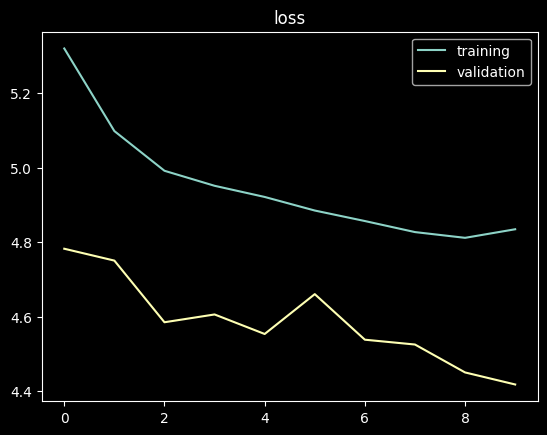

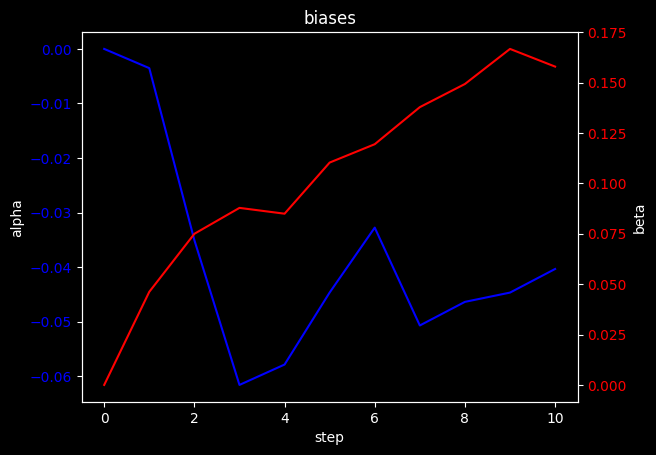

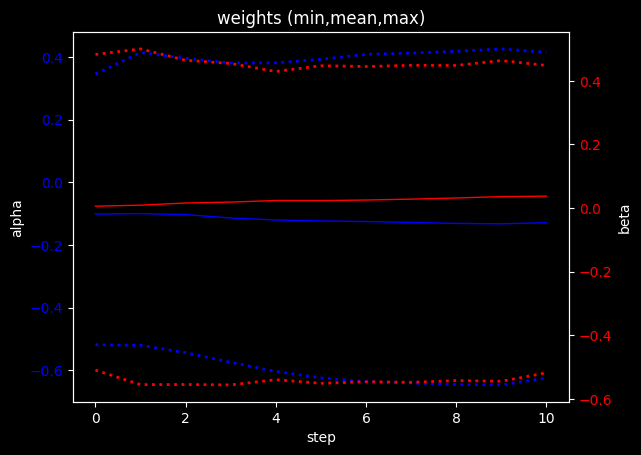

In [23]:
plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='validation')
plt.title('loss')
plt.legend()
weightwatcher.plot()

In [24]:
# Make some predictions and put them alongside the real TTE and event indicator values
test_predict = model.predict(test_x)
test_predict = np.resize(test_predict, (100, 2))
test_result = np.concatenate((test_y, test_predict), axis=1)

2023-02-08 14:01:58.794005: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 4s 1s/step


In [25]:
test_results_df = pd.DataFrame(test_result, columns=['T', 'E', 'alpha', 'beta'])
test_results_df['unit_number'] = np.arange(1, test_results_df.shape[0]+1)
# test_results_df = pd.concat([test_x_orig, test_results_df], axis=1)
# test_results_df = test_results_df.merge(test_x_orig, on=['unit_number'], how='right')

In [26]:
test_results_df

,T,E,alpha,beta,unit_number
0,112.0,1.0,186.155930,3.086130,1
1,98.0,1.0,143.072266,2.733148,2
2,69.0,1.0,70.044731,2.412778,3
3,82.0,1.0,85.234146,2.781023,4
4,91.0,1.0,99.089310,2.973573,5
5,93.0,1.0,115.566002,2.914661,6
6,91.0,1.0,115.141121,3.581945,7
7,95.0,1.0,90.784370,2.709125,8
8,111.0,1.0,149.979477,2.434232,9
9,96.0,1.0,112.176941,3.180027,10


In [27]:
def weibull_pdf(alpha, beta, t):
    return (beta/alpha) * (t/alpha)**(beta-1)*np.exp(- (t/alpha)**beta)

In [28]:
def weibull_median(alpha, beta):
    return alpha*(-np.log(.5))**(1/beta)

In [29]:
def weibull_mean(alpha, beta):
    return alpha * math.gamma(1 + 1/beta)

In [30]:
def weibull_mode(alpha, beta):
    assert np.all(beta > 1)
    return alpha * ((beta-1)/beta)**(1/beta)

In [31]:
test_results_df['T'].describe()

count    100.000000
mean      75.519997
std       41.764969
min        7.000000
25%       32.750000
50%       86.000000
75%      112.250000
max      145.000000
Name: T, dtype: float64

alpha 92.33304 beta 2.914339


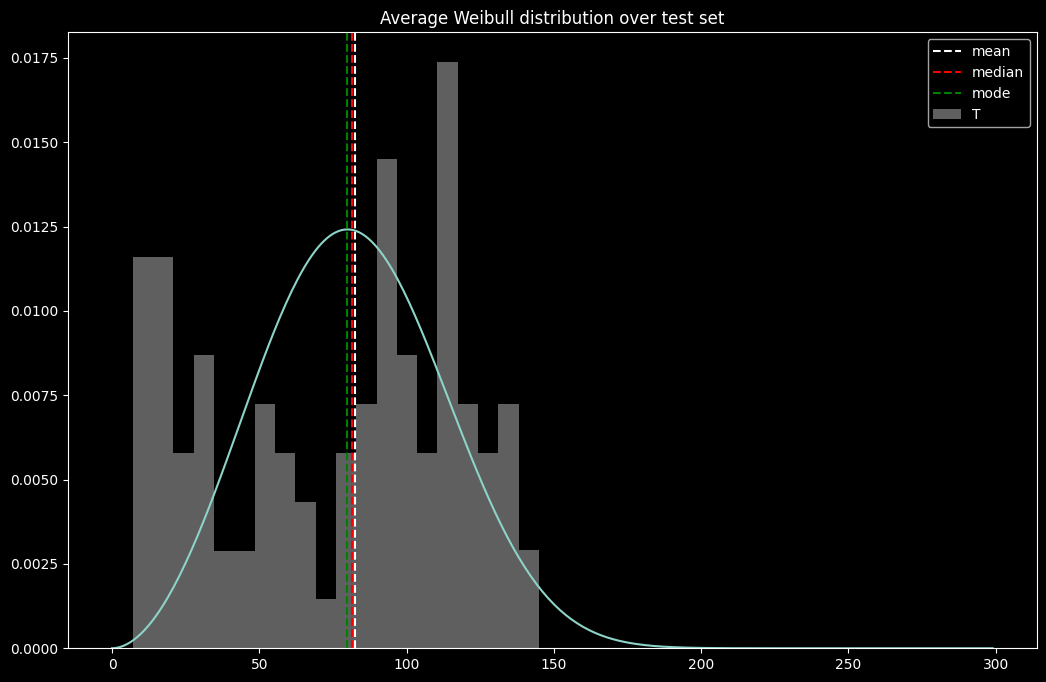

In [33]:
%matplotlib inline
import math
import matplotlib.pyplot as plt
t=np.arange(0,300)
alpha = test_results_df['alpha'].mean()
beta = test_results_df['beta'].mean()

plt.plot(t, weibull_pdf(alpha,beta, t))
mu = weibull_mean(alpha, beta)
median =weibull_median(alpha, beta)
mode = weibull_mode(alpha, beta)
plt.axvline(mu, ls='--', label='mean')
plt.axvline(median, ls='--', color='red', label='median')
plt.axvline(mode, ls='--', color='green', label='mode')
n, bins, patches = plt.hist(test_results_df['T'], 20, density=1, facecolor='grey', alpha=0.75, label='T')
plt.legend()

plt.gcf().set_size_inches(12.5, 8)
plt.title('Average Weibull distribution over test set')
print('alpha', alpha, 'beta', beta)

In [37]:
palette=sns.color_palette("RdBu_r", 50)

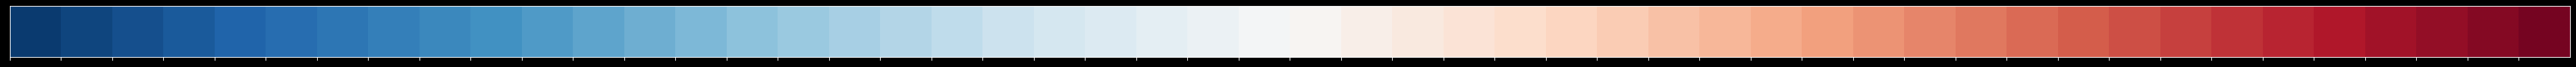

In [38]:
sns.palplot(palette)

In [39]:
train_orig.describe()

,unit_number,time,op_setting_1,op_setting_2,op_setting_3,sensor_measurement_1,sensor_measurement_2,sensor_measurement_3,sensor_measurement_4,sensor_measurement_5,...,sensor_measurement_12,sensor_measurement_13,sensor_measurement_14,sensor_measurement_15,sensor_measurement_16,sensor_measurement_17,sensor_measurement_18,sensor_measurement_19,sensor_measurement_20,sensor_measurement_21
count,20631.000000,20631.000000,20631.000000,20631.000000,20631.0,20631.00,20631.000000,20631.000000,20631.000000,2.063100e+04,...,20631.000000,20631.000000,20631.000000,20631.000000,2.063100e+04,20631.000000,20631.0,20631.0,20631.000000,20631.000000
mean,51.506568,108.807862,-0.000009,0.000002,100.0,518.67,642.680934,1590.523119,1408.933782,1.462000e+01,...,521.413470,2388.096152,8143.752722,8.442146,3.000000e-02,393.210654,2388.0,100.0,38.816271,23.289705
std,29.227633,68.880990,0.002187,0.000293,0.0,0.00,0.500053,6.131150,9.000605,1.776400e-15,...,0.737553,0.071919,19.076176,0.037505,1.387812e-17,1.548763,0.0,0.0,0.180746,0.108251
min,1.000000,1.000000,-0.008700,-0.000600,100.0,518.67,641.210000,1571.040000,1382.250000,1.462000e+01,...,518.690000,2387.880000,8099.940000,8.324900,3.000000e-02,388.000000,2388.0,100.0,38.140000,22.894200
25%,26.000000,52.000000,-0.001500,-0.000200,100.0,518.67,642.325000,1586.260000,1402.360000,1.462000e+01,...,520.960000,2388.040000,8133.245000,8.414900,3.000000e-02,392.000000,2388.0,100.0,38.700000,23.221800
50%,52.000000,104.000000,0.000000,0.000000,100.0,518.67,642.640000,1590.100000,1408.040000,1.462000e+01,...,521.480000,2388.090000,8140.540000,8.438900,3.000000e-02,393.000000,2388.0,100.0,38.830000,23.297900
75%,77.000000,156.000000,0.001500,0.000300,100.0,518.67,643.000000,1594.380000,1414.555000,1.462000e+01,...,521.950000,2388.140000,8148.310000,8.465600,3.000000e-02,394.000000,2388.0,100.0,38.950000,23.366800
max,100.000000,362.000000,0.008700,0.000600,100.0,518.67,644.530000,1616.910000,1441.490000,1.462000e+01,...,523.380000,2388.560000,8293.720000,8.584800,3.000000e-02,400.000000,2388.0,100.0,39.430000,23.618400


In [ ]:
feature_columns = [x for x in test_x_orig.columns if x not in {'unit_number', 'time'}]

mins=train_orig[feature_columns].min()
maxs=train_orig[feature_columns].max()

for unit_no, grp in test_x_orig.groupby('unit_number'):
    df=grp.set_index('time')
    df = df[feature_columns]
    df=(df - mins)/ (maxs - mins)
    df.plot(figsize=(12.5,8))
    plt.title(unit_no)
    plt.show()

In [45]:
def plot_weibull_predictions(results_df):
    fig, axarr = plt.subplots(3, figsize=(20,30))
    t=np.arange(0,400)
    palette = sns.color_palette("RdBu_r", results_df.shape[0] + 1)
    color_dict = dict(enumerate(palette))
    for i, row in enumerate(results_df.iterrows()):
        alpha=row[1]['alpha']
        beta = row[1]['beta']
        T = row[1]['T']
        label = 'a={} b={}'.format(alpha, beta)
        color = color_dict[i]
        ax= axarr[0]
        mode = weibull_mode(alpha, beta)
        y_max = weibull_pdf(alpha, beta, mode)
        ax.plot(t, weibull_pdf(alpha, beta, t), color=color, label=label)
        ax.scatter(T, weibull_pdf(alpha,beta, T), color=color, s=100)
        ax.vlines(mode, ymin=0, ymax=y_max, colors=color, linestyles='--')
        ax.set_title('Weibull distributions')
    ax=axarr[1]   
    median_predictions = weibull_median(results_df['alpha'], results_df['beta'])
    mean_predictions = results_df[['alpha', 'beta']].apply(lambda row: weibull_mean(row[0], row[1]), axis=1)
    mode_predictions = weibull_mode(results_df['alpha'], results_df['beta'])
#     x = results_df['time']    
#     ax.scatter(x, results_df['T'], label='survival_time', color='black')
#     ax.scatter(results_df['T'], median_predictions, label='median_prediction')
#     ax.scatter(results_df['T'], mean_predictions, label='mean_prediction')
    ax.scatter(results_df['T'], mode_predictions, label='m_prediction')
    ax.set_title('MAP prediction Vs. true')  

    ax.legend()
    ax=axarr[2]
    sns.histplot(results_df['T'] - mode_predictions, ax=ax)
    ax.set_title('Error')
    # ax.plot(x, results_df['alpha'], label='alpha')
    # ax.legend()    
    # ax = axarr[3]
    # ax.plot(x, results_df['beta'], label='beta')
    # ax.legend()    
    # ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    # fig.suptitle(title)
    plt.show()

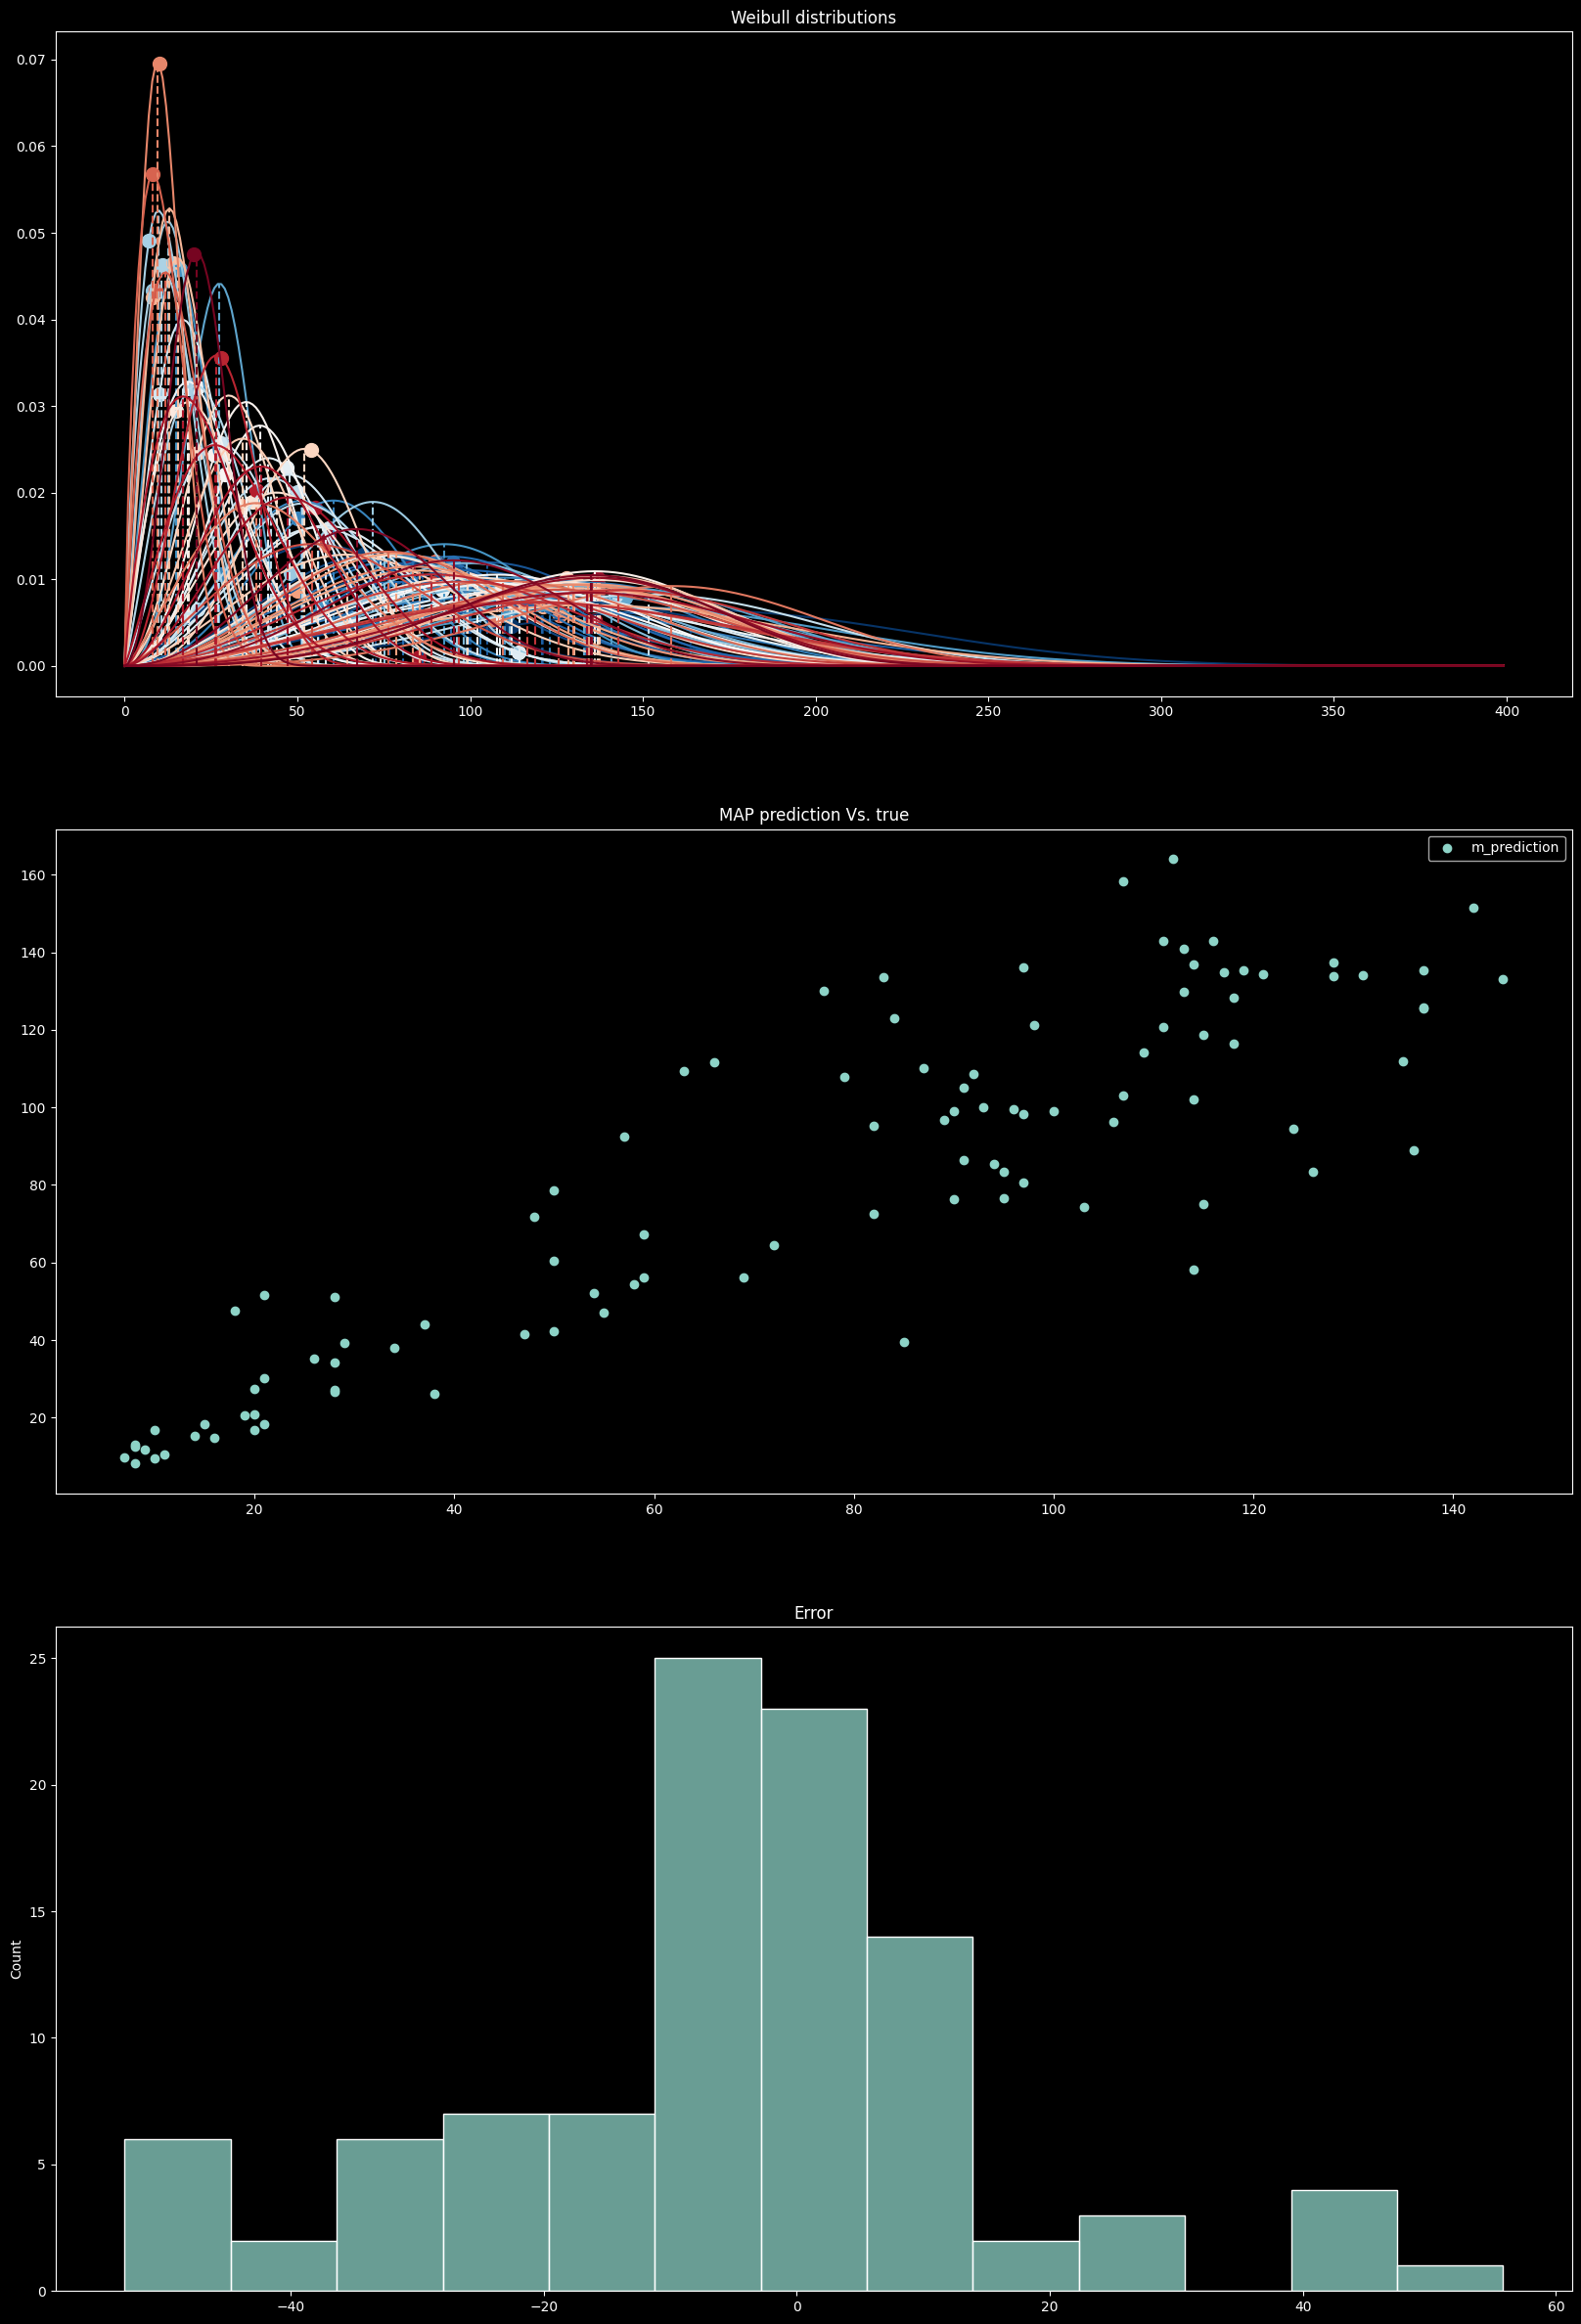

In [46]:
plot_weibull_predictions(results_df=test_results_df)

In [47]:
test_results_df['predicted_mu'] = test_results_df[['alpha', 'beta']].apply(lambda row: weibull_mean(row[0], row[1]), axis=1)
test_results_df['predicted_median'] = test_results_df[['alpha', 'beta']].apply(lambda row: weibull_median(row[0], row[1]), axis=1)
test_results_df['predicted_mode'] = test_results_df[['alpha', 'beta']].apply(lambda row: weibull_mode(row[0], row[1]), axis=1)

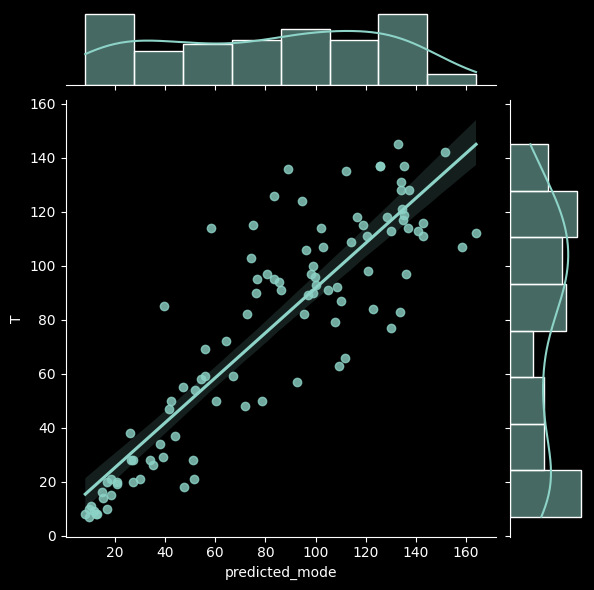

In [48]:
import seaborn as sns
sns.jointplot(data=test_results_df, y='T', x='predicted_mode', kind="reg")

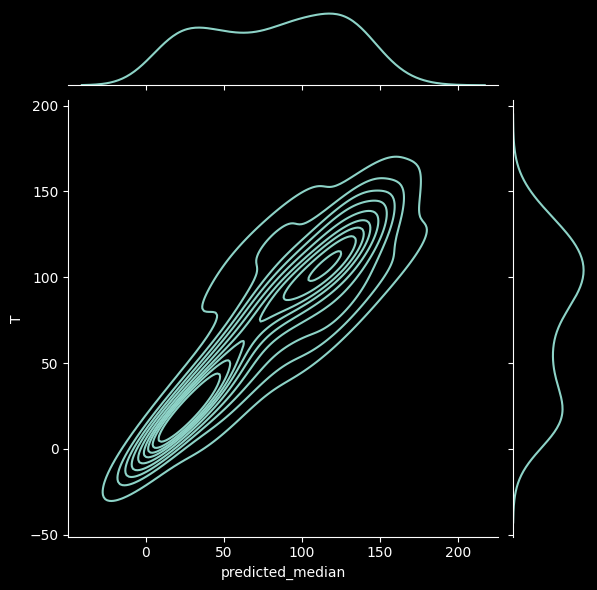

In [49]:
sns.jointplot(data=test_results_df, y='T', x='predicted_median', kind="kde" )

In [50]:
test_results_df['error'] = test_results_df['T']-test_results_df['predicted_median']

In [51]:
test_results_df['error'].describe()

count    100.000000
mean      -6.298154
std       20.303867
min      -53.310133
25%      -15.462119
50%       -6.111908
75%        3.904861
max       54.181770
Name: error, dtype: float64

<AxesSubplot: xlabel='error', ylabel='Count'>

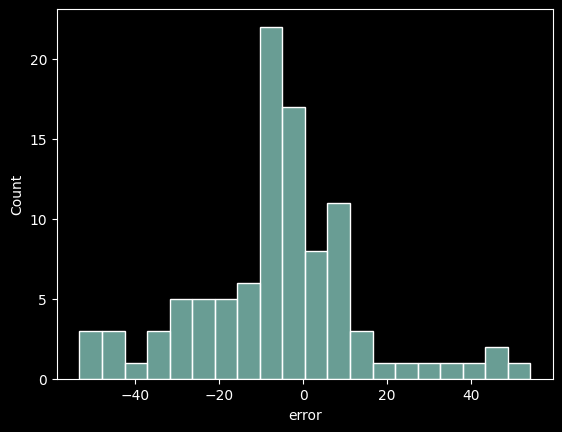

In [53]:
sns.histplot(test_results_df['error'], bins=20)

# Training evaluation

In [54]:
test_y.shape

TensorShape([100, 2])

In [55]:
train_y.shape

TensorShape([20631, 2])

In [56]:
train_predict=model.predict(train_x)
# train_predict = np.resize(train_predict, (20631, 2))

645/645 [==============================] - 523s 811ms/step


In [57]:
train_predict.shape

(20631, 2)

In [59]:
train_result = np.concatenate((train_y, train_predict), axis=1)
train_result.shape

(20631, 4)

In [60]:
train_results_df = pd.DataFrame(train_result, columns=['T', 'E', 'alpha', 'beta'])

In [61]:
train_results_df[['unit_number', 'time']] = train_orig[['unit_number', 'time']]

In [62]:
train_results_df['unit_number'].nunique()

100

In [63]:
train_results_df.shape

(20631, 6)

In [64]:
train_results_df.groupby('unit_number')['beta'].describe()

,count,mean,std,min,25%,50%,75%,max
unit_number,,,,,,,,
1,192.0,2.963325,0.471816,1.468503,2.758261,3.089736,3.330077,3.601594
2,287.0,3.472304,0.583524,1.567447,3.202449,3.667605,3.885976,4.235857
3,179.0,3.368777,0.437958,1.672711,3.241204,3.489726,3.664132,4.062704
4,189.0,2.929350,0.378537,1.591683,2.788367,3.038701,3.182360,3.472302
5,269.0,3.627495,0.622998,1.586530,3.333022,3.824943,4.074759,4.411594
6,188.0,2.282861,0.352984,1.147191,2.190570,2.360707,2.520625,2.887563
7,259.0,3.340193,0.620603,1.460497,3.036478,3.520451,3.792089,4.114097
8,150.0,2.219998,0.298106,1.293829,2.079538,2.302618,2.415893,2.765638
9,201.0,3.693320,0.453255,1.574400,3.626736,3.831774,3.979821,4.285789


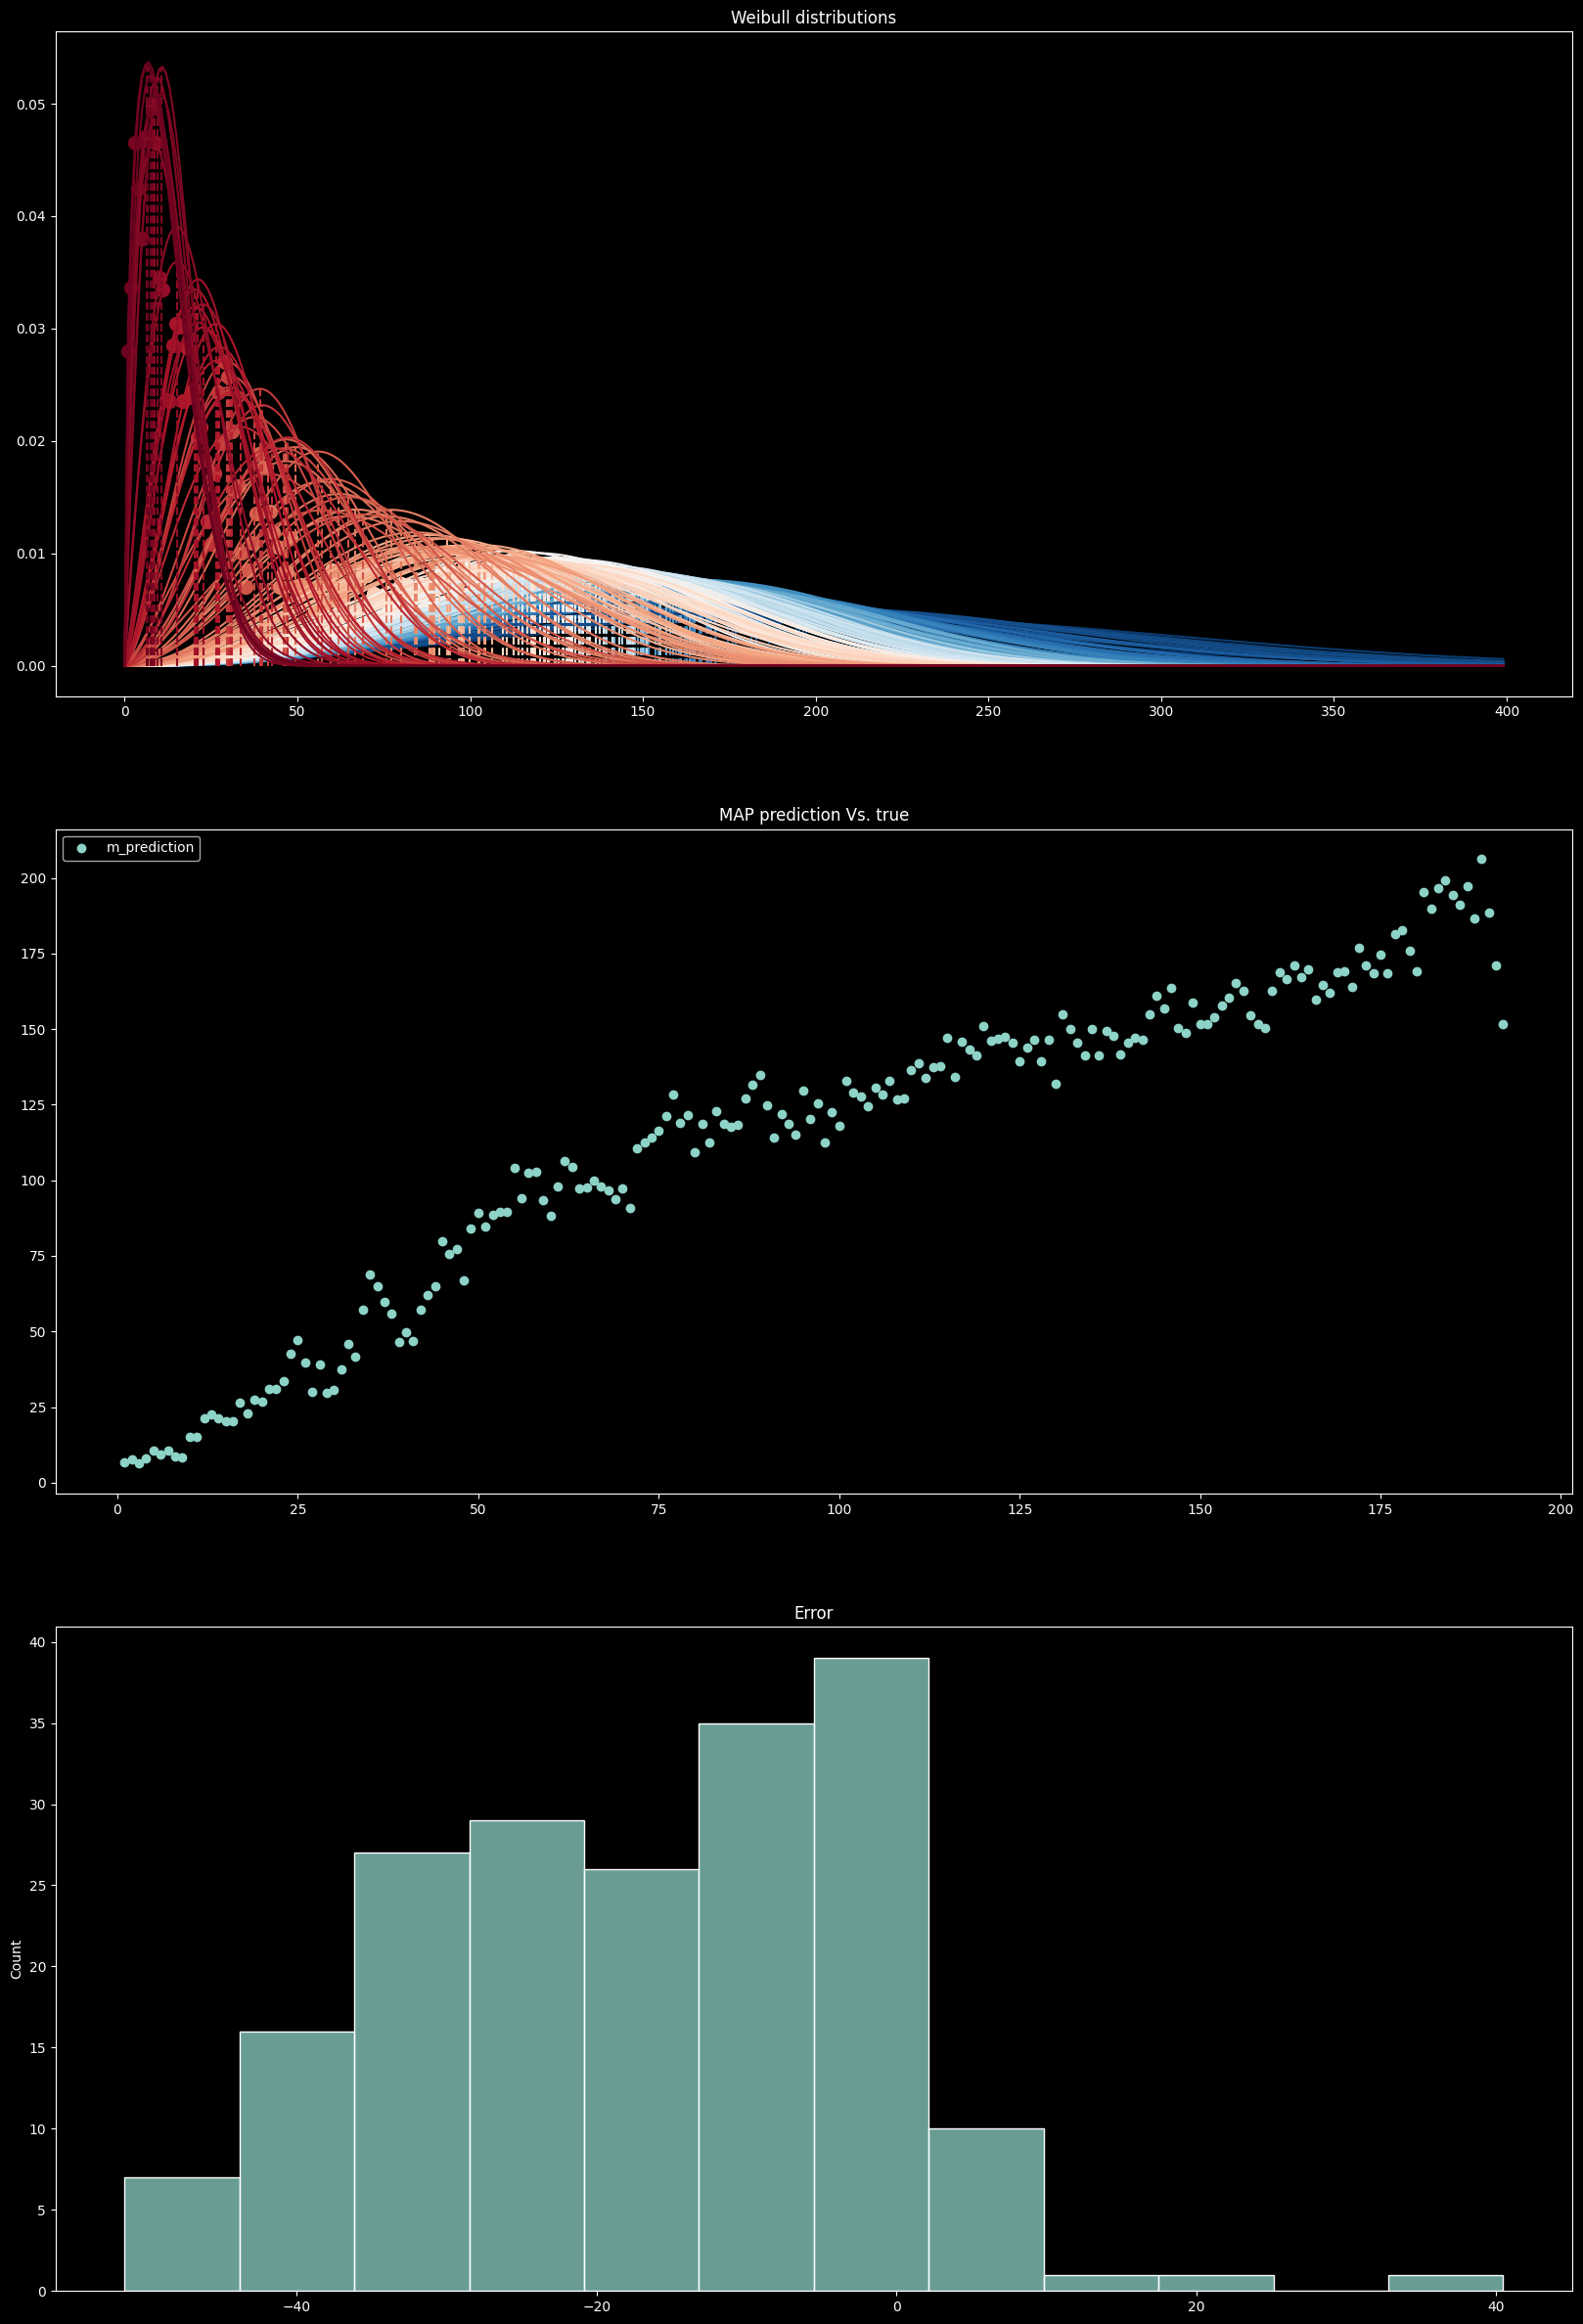

In [75]:
for unit_number, grp in train_results_df.groupby('unit_number'):
    if unit_number < 2:
        plot_weibull_predictions(grp)

In [66]:
train_results_df['predicted_mu'] = train_results_df[['alpha', 'beta']].apply(lambda row: weibull_mean(row[0], row[1]), axis=1)
train_results_df['predicted_median'] = train_results_df[['alpha', 'beta']].apply(lambda row: weibull_median(row[0], row[1]), axis=1)

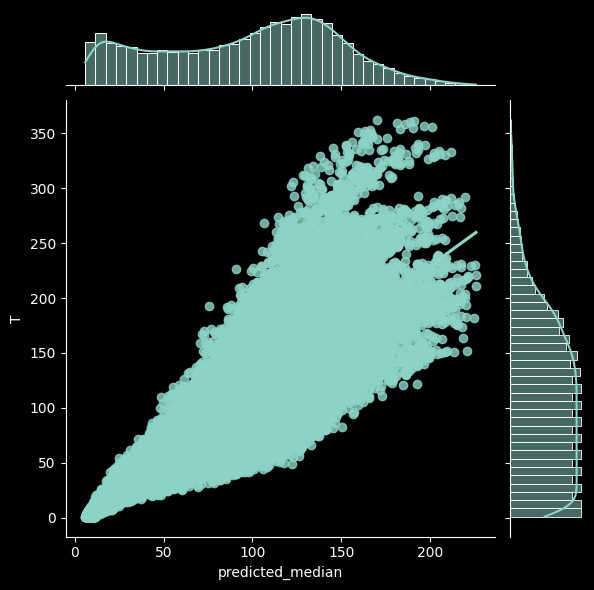

In [67]:
sns.jointplot(data=train_results_df, y='T', x='predicted_median', kind="reg")

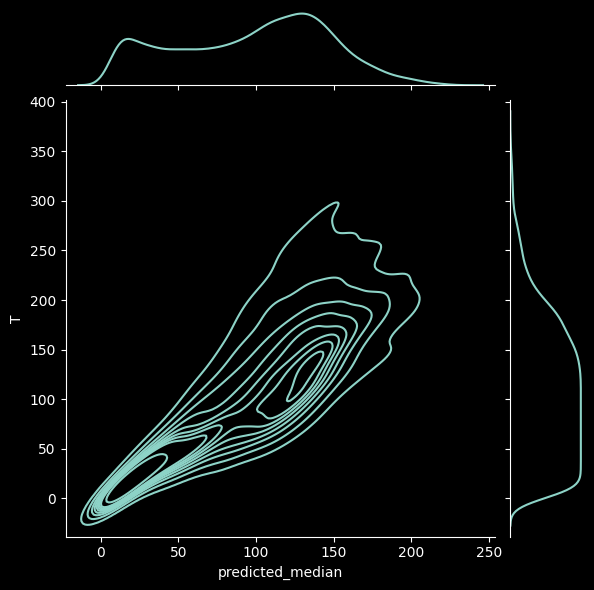

In [68]:
sns.jointplot(data=train_results_df, y='T', x='predicted_median', kind="kde" )

In [69]:
train_results_df['error'] = train_results_df['T']-train_results_df['predicted_median']

In [70]:
train_results_df['error'].describe()

count    20631.000000
mean        11.457743
std         37.911907
min        -73.373537
25%        -10.234197
50%          1.761760
75%         26.384135
max        191.755767
Name: error, dtype: float64

<AxesSubplot: xlabel='error', ylabel='Count'>

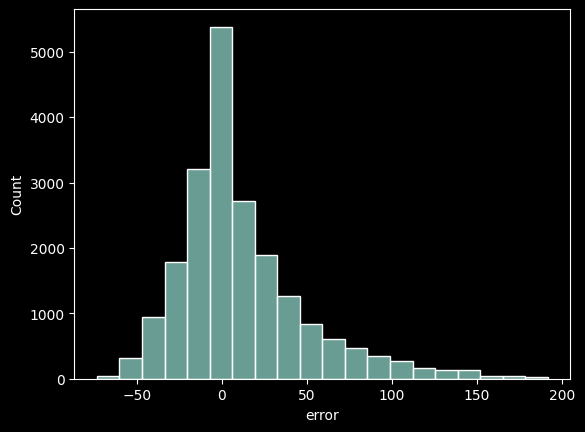

In [72]:
sns.histplot(train_results_df['error'], bins=20)